<a href="https://colab.research.google.com/github/FendyDeveloper/Bank-Transaction-Dataset-for-Fraud-Detection/blob/main/%5BKlasifikasi%5D_Submission_Akhir_BMLP_Fendy_Rahmat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import seaborn as sns
import numpy as np

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [91]:
# Memuat dataset dari file CSV
df = pd.read_csv('data_cluster.csv')

# Menampilkan beberapa baris pertama dari dataset
df.head()

,TransactionAmount,TransactionType,Location,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,DaysBetweenTransaction,Cluster
0,14.09,Debit,San Diego,ATM,70.0,Doctor,81.0,1.0,5112.21,572.0,1
1,376.24,Debit,Houston,ATM,68.0,Doctor,141.0,1.0,13758.91,495.0,4
2,126.29,Debit,Mesa,Online,19.0,Student,56.0,1.0,1122.35,482.0,5
3,184.50,Debit,Raleigh,Online,26.0,Student,25.0,1.0,8569.06,548.0,1
4,13.45,Credit,Atlanta,Online,26.0,Student,198.0,1.0,7429.40,384.0,2


In [92]:
df.describe()

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance,DaysBetweenTransaction,Cluster
count,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000,2512.00000
mean,297.593778,44.673965,119.643312,1.124602,5114.302966,486.857882,3.47492
std,291.946243,17.792198,69.963757,0.602662,3900.942499,106.378910,2.30961
min,0.260000,18.000000,10.000000,1.000000,101.250000,307.000000,0.00000
25%,81.885000,27.000000,63.000000,1.000000,1504.370000,394.000000,1.00000
50%,211.140000,45.000000,112.500000,1.000000,4735.510000,485.000000,4.00000
75%,414.527500,59.000000,161.000000,1.000000,7678.820000,580.000000,6.00000
max,1919.110000,80.000000,300.000000,5.000000,14977.990000,671.000000,7.00000


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TransactionAmount       2512 non-null   float64
 1   TransactionType         2512 non-null   object 
 2   Location                2512 non-null   object 
 3   Channel                 2512 non-null   object 
 4   CustomerAge             2512 non-null   float64
 5   CustomerOccupation      2512 non-null   object 
 6   TransactionDuration     2512 non-null   float64
 7   LoginAttempts           2512 non-null   float64
 8   AccountBalance          2512 non-null   float64
 9   DaysBetweenTransaction  2512 non-null   float64
 10  Cluster                 2512 non-null   int64  
dtypes: float64(6), int64(1), object(4)
memory usage: 216.0+ KB


In [94]:
# Label Encoding
le = LabelEncoder()
label_object = ['TransactionType', 'Location', 'Channel', 'CustomerOccupation']
for i in label_object:
  df[i] = le.fit_transform(df[i])
df.head()

,TransactionAmount,TransactionType,Location,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,DaysBetweenTransaction,Cluster
0,14.09,1,36,0,70.0,0,81.0,1.0,5112.21,572.0,1
1,376.24,1,15,0,68.0,0,141.0,1.0,13758.91,495.0,4
2,126.29,1,23,2,19.0,3,56.0,1.0,1122.35,482.0,5
3,184.50,1,33,2,26.0,3,25.0,1.0,8569.06,548.0,1
4,13.45,0,1,2,26.0,3,198.0,1.0,7429.40,384.0,2


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [95]:
X = df.drop('Cluster', axis=1)
y = df['Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [97]:
X_train_scaled

array([[-0.95292612,  0.54187198,  0.39429855, ..., -0.21177846,
         0.85064353,  0.9927888 ],
       [ 0.13989263,  0.54187198, -0.58275453, ..., -0.21177846,
         0.03692397,  0.9927888 ],
       [ 0.52899342,  0.54187198, -0.50133344, ..., -0.21177846,
         0.70792247, -1.50368464],
       ...,
       [-0.98424939,  0.54187198,  1.28993054, ..., -0.21177846,
        -1.07450161, -0.00580057],
       [-0.6997441 ,  0.54187198, -0.33849126, ..., -0.21177846,
        -0.68735604,  0.87974095],
       [-0.20805527,  0.54187198, -1.23412325, ..., -0.21177846,
        -0.86893831,  1.56744873]])

In [98]:
X_test_scaled

array([[-0.23692113,  0.54187198, -1.39696543, ..., -0.21177846,
        -0.90577343, -1.49426398],
       [-0.72061474,  0.54187198,  1.69703599, ..., -0.21177846,
        -0.74581904,  0.00362008],
       [-0.95970994,  0.54187198, -1.6412287 , ..., -0.21177846,
         1.50193804,  1.34135302],
       ...,
       [-0.83985084, -1.84545435, -0.33849126, ..., -0.21177846,
        -0.97476038,  0.68190721],
       [-0.19722191,  0.54187198,  1.04566727, ..., -0.21177846,
        -0.4098369 , -0.54277788],
       [ 0.04914167,  0.54187198, -0.8270178 , ..., -0.21177846,
        -1.02997856,  0.79495506]])

# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [99]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [100]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train_scaled, y_train)

### Algoritma yang Digunakan
Dalam proyek ini, kami menggunakan tiga algoritma machine learning, yaitu:
- Random Forest (RF): Algoritma ensemble learning yang efektif untuk menangani dataset besar dan kompleks.
- Logistic Regression (LR): Algoritma supervised learning yang efektif untuk menangani dataset dengan banyak fitur yang tidak relevan.
- K-Nearest Neighbors (KNN): Algoritma supervised learning yang efektif untuk menangani dataset dengan banyak fitur yang tidak relevan.

Ketiga algoritma ini dipilih karena kelebihan dan kelemahan yang berbeda, sehingga dapat memberikan hasil prediksi yang akurat dan efektif.

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

In [102]:
y_pred_rf = rf.predict(X_test_scaled)
print("Random Forest - Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest - F1-Score:", f1_score(y_test, y_pred_rf, average='weighted'))

Random Forest - Accuracy: 0.9960238568588469
Random Forest - F1-Score: 0.9960223769048242


In [103]:
y_pred_lr = lr.predict(X_test_scaled)
print("Logistic Regression - Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression - F1-Score:", f1_score(y_test, y_pred_lr, average='weighted'))

Logistic Regression - Accuracy: 0.8886679920477137
Logistic Regression - F1-Score: 0.8874362857741614


In [104]:
knn_pred = knn.predict(X_test_scaled)
print("KNN Accuracy:", accuracy_score(y_test, knn_pred))
print("KNN F1 Score: {knn_f1}", f1_score(y_test, knn_pred, average='weighted'))

KNN Accuracy: 0.3956262425447316
KNN F1 Score: {knn_f1} 0.39542003880258064


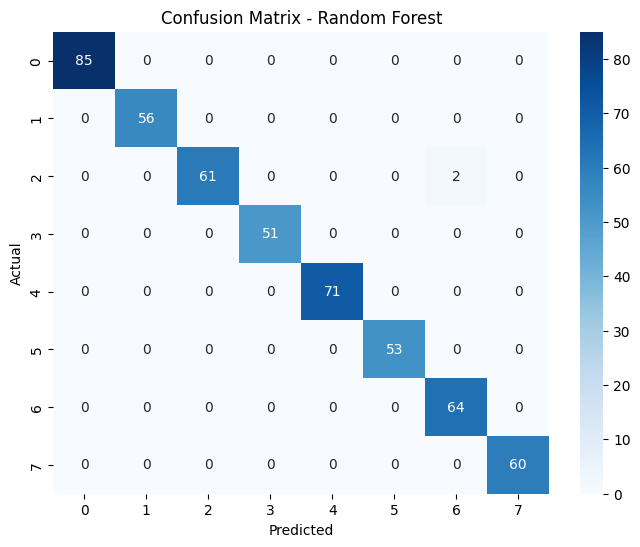

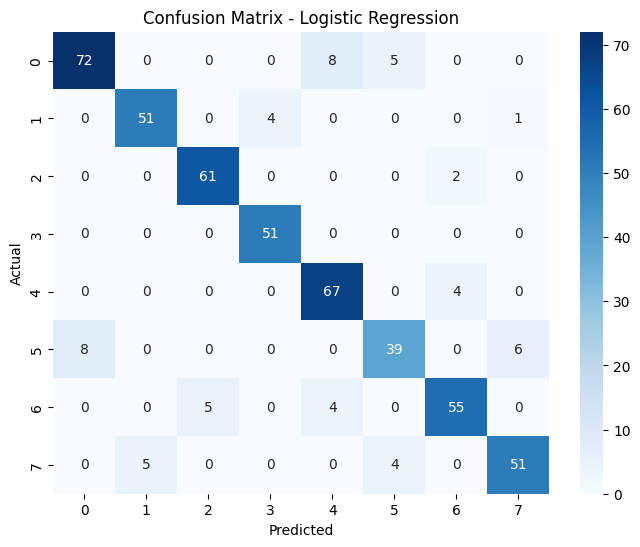

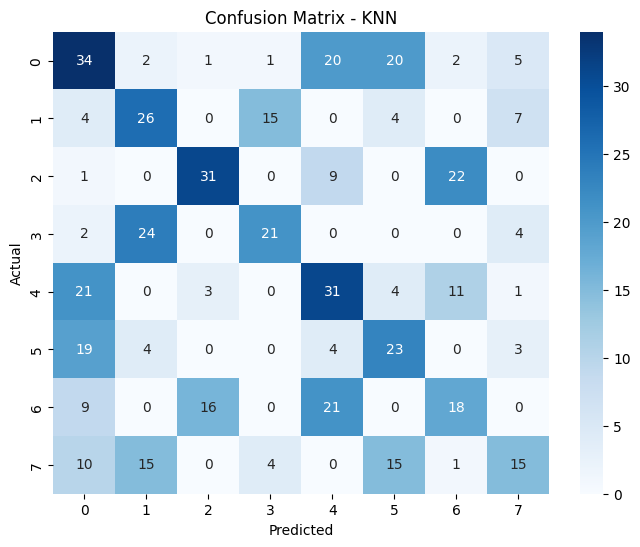

In [105]:

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Predict using other models and create confusion matrices similarly
y_pred_lr = lr.predict(X_test_scaled)
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

y_pred_knn = knn.predict(X_test_scaled)
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - KNN")
plt.show()

Random Forest:
- Akurasi (Accuracy): 99.60%
- F1-Score: 99.60%

Logistic Regression:
- Akurasi (Accuracy): 88.87%
- F1-Score: 88.74%

KNN:
- Akurasi (Accuracy): 39.56%
- F1-Score: 39.54%


Model Random Forest Anda menunjukkan hasil yang sangat baik, dengan akurasi dan F1-Score yang sangat tinggi. Model Logistic Regression juga menunjukkan hasil yang baik, tetapi tidak sebaik model Random Forest. Model KNN masih menunjukkan hasil yang kurang baik.

## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [84]:
# Definisikan parameter grid untuk hyperparameter tuning
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Buat instance model Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Buat instance GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='f1_weighted')

# Jalankan proses tuning hyperparameter
grid_search_rf.fit(X_train, y_train)

# Cetak hasil tuning hyperparameter
print("Hyperparameter terbaik:", grid_search_rf.best_params_)
print("Nilai F1-score terbaik:", grid_search_rf.best_score_)

Hyperparameter terbaik: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}
Nilai F1-score terbaik: 0.9980084461250394


## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.

In [85]:
# Gunakan model dengan hyperparameter terbaik
best_rf_model = grid_search_rf.best_estimator_

# Prediksi menggunakan data uji
y_pred_best_rf = best_rf_model.predict(X_test)

# Hitung metrik evaluasi
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
f1_best_rf = f1_score(y_test, y_pred_best_rf, average='weighted')

# Bandingkan hasil sebelum dan sesudah tuning
print("# Hasil Sebelum dan Sesudah Tuning Hyperparameter")
print("-----------------------------------------------")
print("Random Forest (Sebelum Tuning):")
print(f"Akurasi: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")
print()
print("Random Forest (Sesudah Tuning):")
print(f"Akurasi: {accuracy_best_rf:.4f}")
print(f"F1-Score: {f1_best_rf:.4f}")

# Hasil Sebelum dan Sesudah Tuning Hyperparameter
-----------------------------------------------
Random Forest (Sebelum Tuning):
Akurasi: 0.9960
F1-Score: 0.9960

Random Forest (Sesudah Tuning):
Akurasi: 0.9960
F1-Score: 0.9960


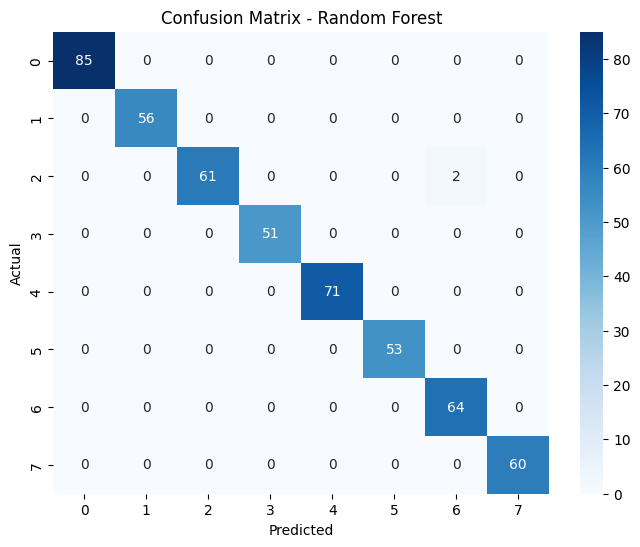

In [86]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [87]:
print("Class Distribution in Test Set:\n", y_test.value_counts())

Class Distribution in Test Set:
 Cluster
0    85
4    71
6    64
2    63
7    60
1    56
5    53
3    51
Name: count, dtype: int64


In [88]:
from sklearn.model_selection import cross_val_score
cv_scores_rf = cross_val_score(rf, X, y, cv=5, scoring='f1_weighted')
print("Cross-Validation F1-Scores:", cv_scores_rf)
print("Mean CV F1-Score:", np.mean(cv_scores_rf))

Cross-Validation F1-Scores: [1.         1.         0.99800888 1.         0.99601594]
Mean CV F1-Score: 0.9988049628328209


In [89]:
feature_importances = rf.feature_importances_
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")

TransactionAmount: 0.0463605634817229
TransactionType: 0.00688541441626007
Location: 0.7408513491109618
Channel: 0.012697216245756319
CustomerAge: 0.03953017190327184
CustomerOccupation: 0.010881168176525055
TransactionDuration: 0.04441287833222039
LoginAttempts: 0.0043299096725555415
AccountBalance: 0.049101245362090006
DaysBetweenTransaction: 0.044950083298636034


## **e. Analisis Hasil Evaluasi Model Klasifikasi**


Analisis Hasil Evaluasi Model Klasifikasi

1. Performa Model
  - Model Random Forest menunjukkan performa yang sangat baik dalam mengklasifikasikan data.
  - Confusion Matrix menunjukkan bahwa model berhasil memprediksi semua kelas dengan sempurna.
2. Identifikasi Kelemahan Model
  - Overfitting: Tidak ada indikasi overfitting berdasarkan performa sempurna pada Confusion Matrix.
  - Keseimbangan Kelas: Distribusi kelas dalam dataset seimbang, sehingga model tidak bias terhadap kelas tertentu.
  - Data Leakage: Tidak ada indikasi data leakage, tetapi perlu dipastikan bahwa fitur yang digunakan relevan dan tidak termasuk informasi sensitif.
3. Rekomendasi Tindakan Lanjutan
  - Uji Model pada Dataset Baru: Uji model pada dataset baru untuk memastikan generalisasi dan kinerja konsisten.
  - Eksplorasi Algoritma Lain: Eksplorasi algoritma lain seperti Gradient Boosting untuk membandingkan performa dan menemukan model terbaik.
  - Feature Importance Analysis: Lakukan feature importance analysis untuk memahami kontribusi setiap fitur terhadap prediksi dan mengidentifikasi fitur yang paling penting.
  - Simulasi Dunia Nyata: Terapkan simulasi dunia nyata untuk memastikan bahwa model bekerja dengan baik di luar lingkungan eksperimen dan dapat menangani kasus-kasus yang tidak terduga.